   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.8 MB/s eta 0:00:00
 Libraries installed successfully!
Libraries imported successfully!


100%|██████████| 573k/573k [00:00<00:00, 74.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/solomonameh/spotify-music-dataset/versions/1
Files in dataset directory: ['high_popularity_spotify_data.csv', 'low_popularity_spotify_data.csv']
Loading dataset from: /root/.cache/kagglehub/datasets/solomonameh/spotify-music-dataset/versions/1/high_popularity_spotify_data.csv
Dataset loaded successfully with 1686 rows
Available columns: ['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness', 'liveness', 'valence', 'track_artist', 'time_signature', 'speechiness', 'track_popularity', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'instrumentalness', 'track_album_id', 'mode', 'key', 'duration_ms', 'acousticness', 'id', 'playlist_subgenre', 'type', 'playlist_id']
Using features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']
Emotion labels: ['Aggressive', 'Calm', 

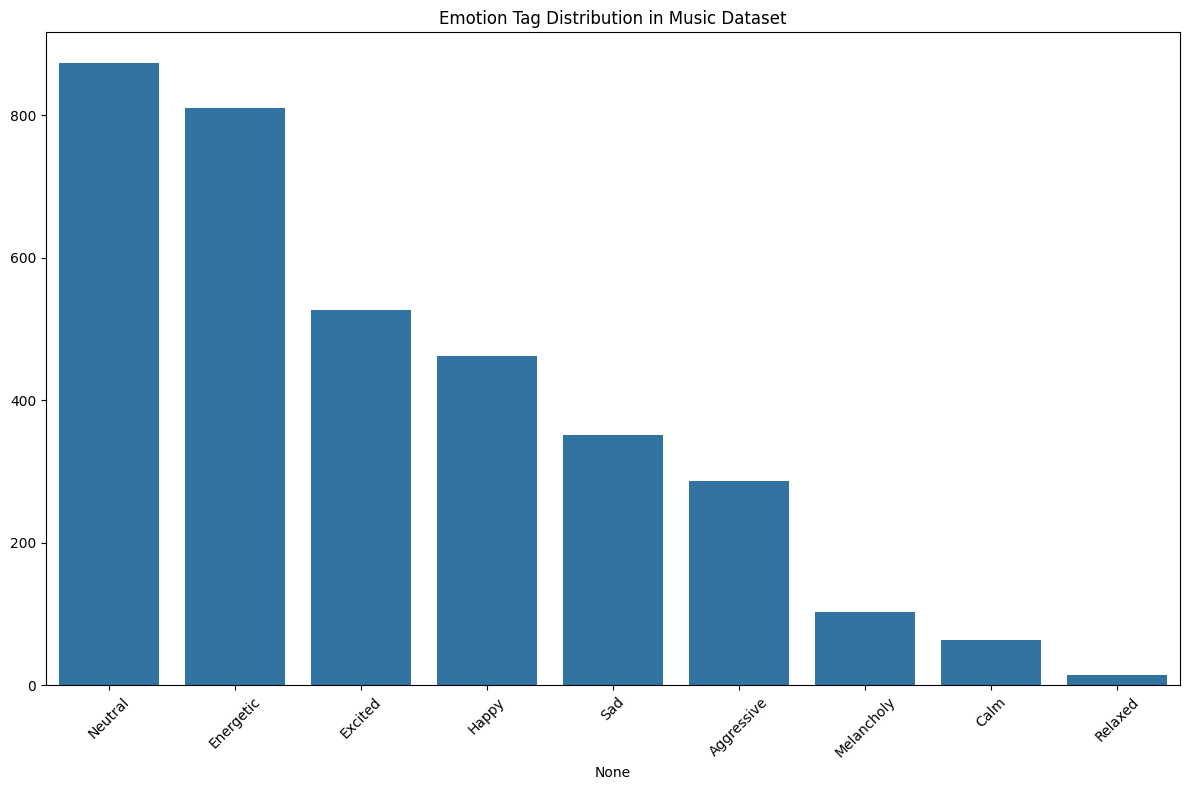

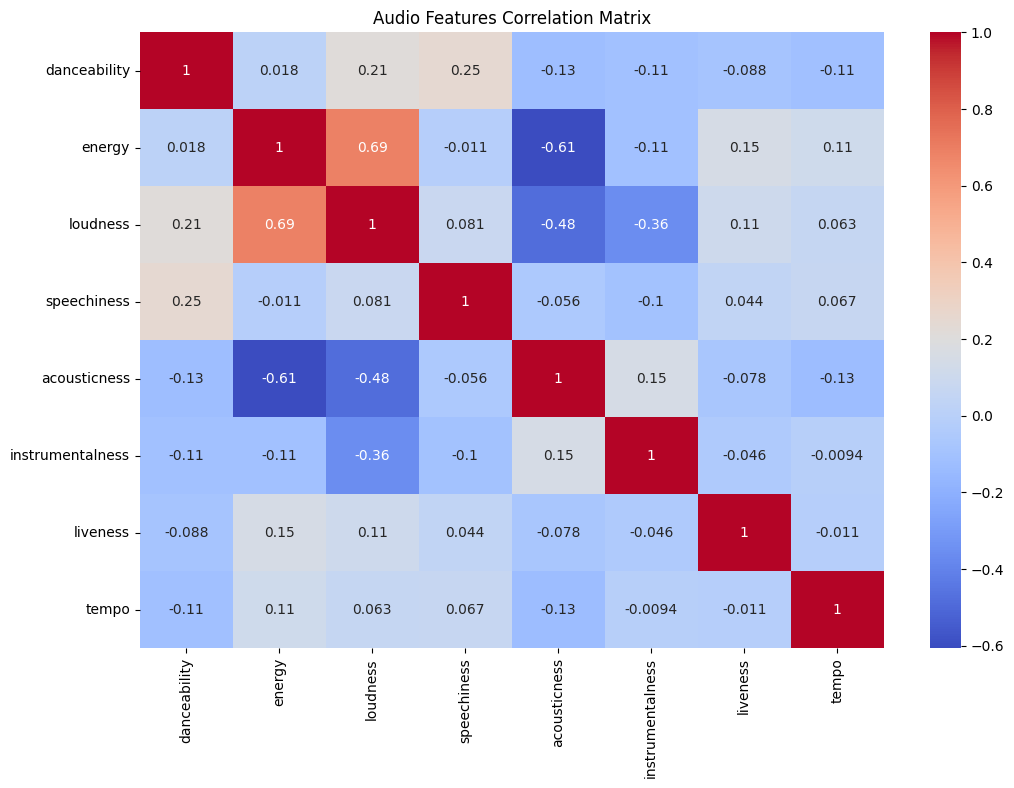


 Training multi-label model...
 Multi-label model trained!
 Multi-label Model Accuracy: 0.4497

 Training single-label model...
 Single-label Model Accuracy: 0.6391


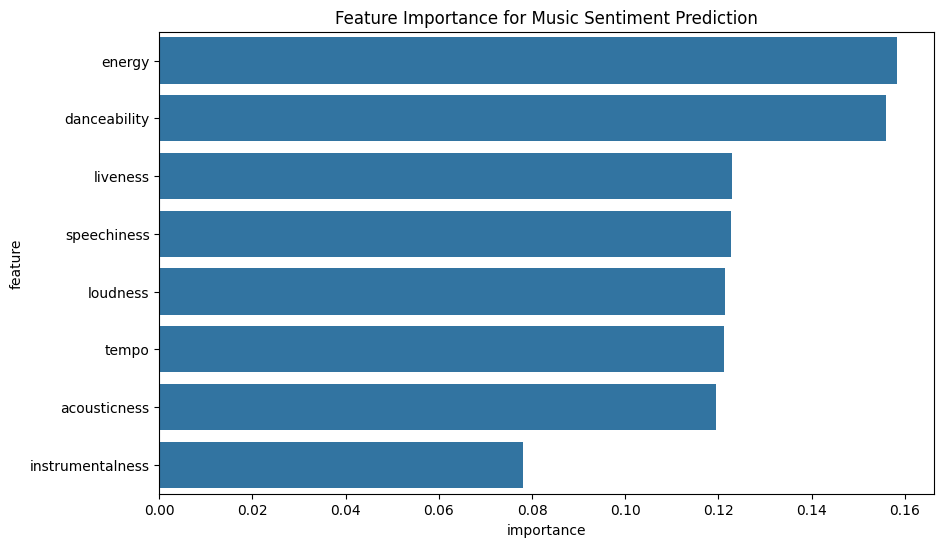


 Models and data saved!

 Test prediction: {'prediction': 'Positive', 'confidence': 0.54, 'feature_contributions': {'danceability': 0.8, 'energy': 0.7, 'loudness': -5.0, 'speechiness': 0.1, 'acousticness': 0.2, 'instrumentalness': 0.0, 'liveness': 0.1, 'tempo': 120.0}}

✅ Streamlit app saved!


/tmp/ipython-input-939403775.py:1581: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as gradio_demo:


In [ ]:
# Step 1: Install all required libraries
!pip install -q kagglehub pandas numpy scikit-learn matplotlib seaborn gradio streamlit flask pyngrok plotly requests

print(" Libraries installed successfully!")

# Step 2: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
import gradio as gr
import os
import kagglehub
import pickle
import threading
import time
import json
from flask import Flask, request, jsonify, render_template_string
from pyngrok import ngrok
import subprocess

print("Libraries imported successfully!")

# Step 3: Load Dataset from Kaggle
print("Downloading dataset from Kaggle")
path = kagglehub.dataset_download("solomonameh/spotify-music-dataset")
print("Path to dataset files:", path)

files = os.listdir(path)
print(f"Files in dataset directory: {files}")

csv_files = [f for f in files if f.endswith('.csv')]
if csv_files:
    csv_path = os.path.join(path, csv_files[0])
    print(f"Loading dataset from: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"Dataset loaded successfully with {len(df)} rows")
    print("Available columns:", df.columns.tolist())
else:
    print("No CSV file found. Creating sample dataset...")
    np.random.seed(42)
    n_samples = 1000
    df = pd.DataFrame({
        'danceability': np.random.uniform(0, 1, n_samples),
        'energy': np.random.uniform(0, 1, n_samples),
        'loudness': np.random.uniform(-20, 0, n_samples),
        'speechiness': np.random.uniform(0, 1, n_samples),
        'acousticness': np.random.uniform(0, 1, n_samples),
        'instrumentalness': np.random.uniform(0, 1, n_samples),
        'liveness': np.random.uniform(0, 1, n_samples),
        'tempo': np.random.uniform(60, 200, n_samples),
        'valence': np.random.uniform(0, 1, n_samples),
        'track_name': [f'Track {i}' for i in range(n_samples)],
        'artist_name': [f'Artist {i%100}' for i in range(n_samples)]
    })
    print(f" Sample dataset created with {len(df)} rows")

# Step 4: Data Preprocessing and Multi-label Emotion Creation
def create_emotion_tags(valence, energy):
    """Create multiple emotion tags based on valence and energy values"""
    tags = []

    if valence >= 0.7:
        tags.append("Happy")
    elif valence <= 0.3:
        tags.append("Sad")
    else:
        tags.append("Neutral")

    if energy >= 0.7:
        tags.append("Energetic")
    elif energy <= 0.3:
        tags.append("Calm")

    if valence >= 0.6 and energy >= 0.6:
        tags.append("Excited")
    elif valence <= 0.4 and energy <= 0.4:
        tags.append("Melancholy")
    elif valence >= 0.6 and energy <= 0.4:
        tags.append("Relaxed")
    elif valence <= 0.4 and energy >= 0.6:
        tags.append("Aggressive")

    return tags

# Apply emotion tags
if 'valence' in df.columns and 'energy' in df.columns:
    df['emotion_tags'] = df.apply(lambda row: create_emotion_tags(row['valence'], row['energy']), axis=1)
else:
    all_tags = ["Happy", "Sad", "Neutral", "Energetic", "Calm", "Excited", "Melancholy", "Relaxed", "Aggressive"]
    df['emotion_tags'] = [np.random.choice(all_tags, size=np.random.randint(1, 4), replace=False).tolist()
                          for _ in range(len(df))]

# Create binary columns for each emotion tag
mlb = MultiLabelBinarizer()
emotion_dummies = pd.DataFrame(mlb.fit_transform(df['emotion_tags']),
                              columns=mlb.classes_,
                              index=df.index)
df = pd.concat([df, emotion_dummies], axis=1)

# Select feature columns
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness',
               'acousticness', 'instrumentalness', 'liveness', 'tempo']

available_features = [col for col in feature_cols if col in df.columns]
emotion_columns = mlb.classes_.tolist()

print(f"Using features: {available_features}")
print(f"Emotion labels: {emotion_columns}")

# Remove missing values
df_clean = df.dropna(subset=available_features + emotion_columns)
df_clean = df_clean.reset_index(drop=True)
print(f" Clean dataset size: {len(df_clean)}")

# Step 5: Exploratory Data Analysis
plt.figure(figsize=(12, 8))
emotion_counts = df_clean[emotion_columns].sum().sort_values(ascending=False)
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Emotion Tag Distribution in Music Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df_clean[available_features].corr(), annot=True, cmap='coolwarm')
plt.title('Audio Features Correlation Matrix')
plt.show()

# Step 6: Model Training
X = df_clean[available_features]
y = df_clean[emotion_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\n Training multi-label model...")
multi_label_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
multi_label_model.fit(X_train, y_train)

y_pred = multi_label_model.predict(X_test)
print(" Multi-label model trained!")
accuracy = accuracy_score(y_test, y_pred)
print(f" Multi-label Model Accuracy: {accuracy:.4f}")

# Train single-label model
df_clean['sentiment'] = df_clean['valence'].apply(lambda v: "Positive" if v >= 0.6 else ("Negative" if v <= 0.4 else "Neutral"))
y_single = df_clean['sentiment']
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(
    X, y_single, test_size=0.2, random_state=42, stratify=y_single
)

print("\n Training single-label model...")
single_label_model = RandomForestClassifier(n_estimators=100, random_state=42)
single_label_model.fit(X_train_single, y_train_single)

y_pred_single = single_label_model.predict(X_test_single)
accuracy = accuracy_score(y_test_single, y_pred_single)
print(f" Single-label Model Accuracy: {accuracy:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': single_label_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Music Sentiment Prediction')
plt.show()

# Save models and data
with open('multi_label_model.pkl', 'wb') as f:
    pickle.dump(multi_label_model, f)
with open('single_label_model.pkl', 'wb') as f:
    pickle.dump(single_label_model, f)
with open('mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)

df_clean.to_csv('music_data.csv', index=False)

print("\n Models and data saved!")

# Step 7: Create Prediction Functions
def predict_music_sentiment(danceability, energy, loudness, speechiness,
                          acousticness, instrumentalness, liveness, tempo):
    """Predict music emotional tendency (single-label)"""
    input_features = pd.DataFrame([{
        'danceability': danceability,
        'energy': energy,
        'loudness': loudness,
        'speechiness': speechiness,
        'acousticness': acousticness,
        'instrumentalness': instrumentalness,
        'liveness': liveness,
        'tempo': tempo
    }])

    prediction = single_label_model.predict(input_features)[0]
    confidence = max(single_label_model.predict_proba(input_features)[0])

    return {
        "prediction": prediction,
        "confidence": float(confidence),
        "feature_contributions": {
            'danceability': danceability,
            'energy': energy,
            'loudness': loudness,
            'speechiness': speechiness,
            'acousticness': acousticness,
            'instrumentalness': instrumentalness,
            'liveness': liveness,
            'tempo': tempo
        }
    }

def predict_music_emotions(danceability, energy, loudness, speechiness,
                          acousticness, instrumentalness, liveness, tempo):
    """Predict multiple emotion tags for music"""
    input_features = pd.DataFrame([{
        'danceability': danceability,
        'energy': energy,
        'loudness': loudness,
        'speechiness': speechiness,
        'acousticness': acousticness,
        'instrumentalness': instrumentalness,
        'liveness': liveness,
        'tempo': tempo
    }])

    predictions = multi_label_model.predict(input_features)[0]
    probabilities = multi_label_model.predict_proba(input_features)

    emotion_probs = {}
    for i, emotion in enumerate(emotion_columns):
        prob = probabilities[i][0][1] if len(probabilities[i][0]) > 1 else probabilities[i][0][0]
        emotion_probs[emotion] = float(prob)

    predicted_emotions = [emotion for i, emotion in enumerate(emotion_columns) if predictions[i] == 1]

    return {
        "predicted_emotions": predicted_emotions,
        "emotion_probabilities": emotion_probs,
        "feature_contributions": {
            'danceability': danceability,
            'energy': energy,
            'loudness': loudness,
            'speechiness': speechiness,
            'acousticness': acousticness,
            'instrumentalness': instrumentalness,
            'liveness': liveness,
            'tempo': tempo
        }
    }

def recommend_similar_songs(song_index, num_recommendations=5):
    """Recommend songs similar to the given song index"""
    try:
        song_features = df_clean.iloc[song_index][available_features].to_frame().T
        knn = NearestNeighbors(n_neighbors=num_recommendations+1, metric='euclidean')
        knn.fit(df_clean[available_features])
        distances, indices = knn.kneighbors(song_features)

        recommended_indices = indices[0][1:]
        recommended_songs = df_clean.iloc[recommended_indices]

        results = []
        for idx, row in enumerate(recommended_songs.iterrows()):
            _, song_data = row
            song_info = {
                "track_name": str(song_data.get("track_name", f"Track {recommended_indices[idx]}")),
                "artist_name": str(song_data.get("artist_name", f"Artist {recommended_indices[idx]}")),
                "sentiment": str(song_data.get("sentiment", "Unknown")),
                "emotion_tags": song_data.get("emotion_tags", []),
                "similarity": float(1 - (distances[0][idx+1] / max(distances[0])))
            }
            results.append(song_info)

        return results
    except Exception as e:
        print(f"Error in recommendation: {e}")
        return []

# Test functions
test_result = predict_music_sentiment(0.8, 0.7, -5.0, 0.1, 0.2, 0.0, 0.1, 120.0)
print("\n Test prediction:", test_result)


# STREAMLIT APPLICATION


STREAMLIT_CODE = '''
import streamlit as st
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.neighbors import NearestNeighbors

st.set_page_config(
    page_title="🎵 Music Sentiment Analyzer",
    page_icon="🎵",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS
st.markdown("""
<style>
    .main {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    }
    .stApp {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    }
    h1, h2, h3 {
        color: white;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
    }
    .stButton>button {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        border-radius: 10px;
        padding: 10px 20px;
        font-weight: 600;
    }
</style>
""", unsafe_allow_html=True)

# Load models and data
@st.cache_resource
def load_models():
    try:
        with open('multi_label_model.pkl', 'rb') as f:
            multi_model = pickle.load(f)
        with open('single_label_model.pkl', 'rb') as f:
            single_model = pickle.load(f)
        with open('mlb.pkl', 'rb') as f:
            mlb_obj = pickle.load(f)
        df = pd.read_csv('music_data.csv')
        return multi_model, single_model, mlb_obj, df
    except:
        st.error(" Models not found. Please train models first.")
        return None, None, None, None

multi_label_model, single_label_model, mlb, df_clean = load_models()

feature_cols = ['danceability', 'energy', 'loudness', 'speechiness',
               'acousticness', 'instrumentalness', 'liveness', 'tempo']

# Sidebar
with st.sidebar:
    st.markdown("# 🎵 Navigation")
    page = st.radio("Choose a page:", [
        "🏠 Home",
        "🎯 Single-Label Analysis",
        "🎨 Multi-Label Analysis",
        "🎼 Song Recommendations",
        "📊 Dataset Analytics"
    ])

    st.markdown("---")
    st.markdown("### 📈 Model Info")
    st.metric("Training Samples", len(df_clean) if df_clean is not None else 0)
    st.metric("Features", len(feature_cols))
    st.metric("Emotion Labels", len(mlb.classes_) if mlb is not None else 0)

# Home Page
if page == "🏠 Home":
    st.markdown("<h1 style='text-align: center;'>🎵 Music Sentiment Analyzer</h1>", unsafe_allow_html=True)
    st.markdown("<p style='text-align: center; color: white; font-size: 1.2em;'>Analyze music emotions using AI and machine learning</p>", unsafe_allow_html=True)

    col1, col2, col3 = st.columns(3)

    with col1:
        st.markdown("""
        <div style='background: rgba(255,255,255,0.1); padding: 20px; border-radius: 10px; color: white;'>
        <h3>🎯 Single-Label</h3>
        <p>Classify music into Positive, Negative, or Neutral sentiment</p>
        </div>
        """, unsafe_allow_html=True)

    with col2:
        st.markdown("""
        <div style='background: rgba(255,255,255,0.1); padding: 20px; border-radius: 10px; color: white;'>
        <h3>🎨 Multi-Label</h3>
        <p>Detect multiple emotions like Happy, Sad, Energetic, Calm</p>
        </div>
        """, unsafe_allow_html=True)

    with col3:
        st.markdown("""
        <div style='background: rgba(255,255,255,0.1); padding: 20px; border-radius: 10px; color: white;'>
        <h3>🎼 Recommendations</h3>
        <p>Find similar songs based on audio features</p>
        </div>
        """, unsafe_allow_html=True)

# Single-Label Analysis
elif page == "🎯 Single-Label Analysis":
    st.markdown("<h1>🎯 Single-Label Sentiment Analysis</h1>", unsafe_allow_html=True)

    if single_label_model is None:
        st.error("Model not loaded")
        st.stop()

    col1, col2 = st.columns(2)

    with col1:
        danceability = st.slider("🕺 Danceability", 0.0, 1.0, 0.5, 0.01)
        energy = st.slider("⚡ Energy", 0.0, 1.0, 0.5, 0.01)
        loudness = st.slider("🔊 Loudness (dB)", -60.0, 0.0, -10.0, 1.0)
        speechiness = st.slider("🗣️ Speechiness", 0.0, 1.0, 0.1, 0.01)

    with col2:
        acousticness = st.slider("🎸 Acousticness", 0.0, 1.0, 0.5, 0.01)
        instrumentalness = st.slider("🎹 Instrumentalness", 0.0, 1.0, 0.0, 0.01)
        liveness = st.slider("🎤 Liveness", 0.0, 1.0, 0.1, 0.01)
        tempo = st.slider("🥁 Tempo (BPM)", 0.0, 250.0, 120.0, 1.0)

    if st.button("🔍 Analyze Sentiment", key="single"):
        input_features = pd.DataFrame([{
            'danceability': danceability,
            'energy': energy,
            'loudness': loudness,
            'speechiness': speechiness,
            'acousticness': acousticness,
            'instrumentalness': instrumentalness,
            'liveness': liveness,
            'tempo': tempo
        }])

        prediction = single_label_model.predict(input_features)[0]
        confidence = max(single_label_model.predict_proba(input_features)[0])

        st.markdown(f"""
        <div style='background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);
        padding: 30px; border-radius: 15px; color: white; text-align: center;'>
        <h2>🎵 Predicted Sentiment: {prediction}</h2>
        <h3>Confidence: {confidence:.2%}</h3>
        </div>
        """, unsafe_allow_html=True)

        # Confidence gauge
        fig = go.Figure(go.Indicator(
            mode="gauge+number",
            value=confidence * 100,
            title={'text': "Confidence"},
            gauge={'axis': {'range': [0, 100]},
                   'bar': {'color': "darkgreen"}}
        ))
        st.plotly_chart(fig, use_container_width=True)

# Multi-Label Analysis
elif page == "🎨 Multi-Label Analysis":
    st.markdown("<h1>🎨 Multi-Label Emotion Analysis</h1>", unsafe_allow_html=True)

    if multi_label_model is None:
        st.error("Model not loaded")
        st.stop()

    col1, col2 = st.columns(2)

    with col1:
        danceability = st.slider("🕺 Danceability", 0.0, 1.0, 0.5, 0.01, key="m_dance")
        energy = st.slider("⚡ Energy", 0.0, 1.0, 0.5, 0.01, key="m_energy")
        loudness = st.slider("🔊 Loudness (dB)", -60.0, 0.0, -10.0, 1.0, key="m_loud")
        speechiness = st.slider("🗣️ Speechiness", 0.0, 1.0, 0.1, 0.01, key="m_speech")

    with col2:
        acousticness = st.slider("🎸 Acousticness", 0.0, 1.0, 0.5, 0.01, key="m_acoustic")
        instrumentalness = st.slider("🎹 Instrumentalness", 0.0, 1.0, 0.0, 0.01, key="m_inst")
        liveness = st.slider("🎤 Liveness", 0.0, 1.0, 0.1, 0.01, key="m_live")
        tempo = st.slider("🥁 Tempo (BPM)", 0.0, 250.0, 120.0, 1.0, key="m_tempo")

    if st.button("🔍 Analyze Emotions", key="multi"):
        input_features = pd.DataFrame([{
            'danceability': danceability,
            'energy': energy,
            'loudness': loudness,
            'speechiness': speechiness,
            'acousticness': acousticness,
            'instrumentalness': instrumentalness,
            'liveness': liveness,
            'tempo': tempo
        }])

        predictions = multi_label_model.predict(input_features)[0]
        probabilities = multi_label_model.predict_proba(input_features)

        predicted_emotions = [emotion for i, emotion in enumerate(mlb.classes_) if predictions[i] == 1]

        st.markdown(f"""
        <div style='background: linear-gradient(135deg, #ee0979 0%, #ff6a00 100%);
        padding: 30px; border-radius: 15px; color: white; text-align: center;'>
        <h2>🎨 Predicted Emotions</h2>
        <h3>{", ".join(predicted_emotions)}</h3>
        </div>
        """, unsafe_allow_html=True)

        # Emotion probabilities
        emotion_probs = {}
        for i, emotion in enumerate(mlb.classes_):
            prob = probabilities[i][0][1] if len(probabilities[i][0]) > 1 else probabilities[i][0][0]
            emotion_probs[emotion] = prob

        fig = px.bar(
            x=list(emotion_probs.keys()),
            y=list(emotion_probs.values()),
            labels={'x': 'Emotion', 'y': 'Probability'},
            title='Emotion Probabilities'
        )
        st.plotly_chart(fig, use_container_width=True)

# Song Recommendations
elif page == "🎼 Song Recommendations":
    st.markdown("<h1>🎼 Song Recommendation System</h1>", unsafe_allow_html=True)

    if df_clean is None:
        st.error("Data not loaded")
        st.stop()

    song_options = []
    for i, row in df_clean.iterrows():
        track = str(row.get('track_name', f'Track {i}'))[:50]
        artist = str(row.get('artist_name', f'Artist {i}'))[:30]
        song_options.append(f"{i}: {track} by {artist}")

    selected_song = st.selectbox("🎵 Select a Song", song_options[:100])
    num_recs = st.slider("Number of Recommendations", 1, 10, 5)

    if st.button("🔍 Get Recommendations"):
        try:
            song_index = int(selected_song.split(":")[0])

            song_features = df_clean.iloc[song_index][feature_cols].to_frame().T
            knn = NearestNeighbors(n_neighbors=num_recs+1, metric='euclidean')
            knn.fit(df_clean[feature_cols])
            distances, indices = knn.kneighbors(song_features)

            st.markdown("### 🎵 Selected Song")
            selected_info = df_clean.iloc[song_index]
            st.write(f"**Track:** {selected_info.get('track_name', 'Unknown')}")
            st.write(f"**Artist:** {selected_info.get('artist_name', 'Unknown')}")

            st.markdown("### 🎼 Recommendations")
            for idx in indices[0][1:]:
                rec = df_clean.iloc[idx]
                st.markdown(f"""
                <div style='background: rgba(255,255,255,0.1); padding: 15px;
                border-radius: 10px; margin: 10px 0; color: white;'>
                <h4>{rec.get('track_name', 'Unknown')}</h4>
                <p>Artist: {rec.get('artist_name', 'Unknown')}</p>
                <p>Sentiment: {rec.get('sentiment', 'Unknown')}</p>
                </div>
                """, unsafe_allow_html=True)
        except Exception as e:
            st.error(f"Error: {str(e)}")

# Dataset Analytics
elif page == "📊 Dataset Analytics":
    st.markdown("<h1>📊 Dataset Analytics</h1>", unsafe_allow_html=True)

    if df_clean is None:
        st.error("Data not loaded")
        st.stop()

    st.markdown("### Dataset Overview")
    st.write(f"Total Songs: {len(df_clean)}")

    # Feature distributions
    st.markdown("### Feature Distributions")
    feature = st.selectbox("Select Feature", feature_cols)
    fig = px.histogram(df_clean, x=feature, title=f'{feature.capitalize()} Distribution')
    st.plotly_chart(fig, use_container_width=True)

    # Correlation matrix
    st.markdown("### Feature Correlations")
    corr = df_clean[feature_cols].corr()
    fig = px.imshow(corr, text_auto=True, aspect="auto")
    st.plotly_chart(fig, use_container_width=True)
'''

# Write Streamlit code to file
with open('streamlit_music_app.py', 'w') as f:
    f.write(STREAMLIT_CODE)

print("\n✅ Streamlit app saved!")


# FLASK APPLICATION


flask_app = Flask(__name__)

FLASK_HTML = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>🎵 Music Sentiment Analyzer - Professional Edition</title>
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700&display=swap" rel="stylesheet">
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0/css/all.min.css">
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }

        body {
            font-family: 'Poppins', sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            min-height: 100vh;
            padding: 20px;
        }

        .container {
            max-width: 1400px;
            margin: 0 auto;
        }

        .header {
            text-align: center;
            color: white;
            margin-bottom: 40px;
            animation: fadeInDown 0.8s ease;
        }

        .header h1 {
            font-size: 3em;
            font-weight: 700;
            margin-bottom: 10px;
            text-shadow: 2px 2px 8px rgba(0,0,0,0.3);
        }

        .header p {
            font-size: 1.2em;
            opacity: 0.9;
        }

        .main-card {
            background: white;
            border-radius: 25px;
            padding: 40px;
            box-shadow: 0 20px 60px rgba(0,0,0,0.3);
            animation: fadeInUp 0.8s ease;
        }

        .tabs {
            display: flex;
            gap: 10px;
            margin-bottom: 30px;
            border-bottom: 2px solid #f0f0f0;
            flex-wrap: wrap;
        }

        .tab {
            padding: 15px 30px;
            background: transparent;
            border: none;
            border-bottom: 3px solid transparent;
            color: #666;
            font-size: 16px;
            font-weight: 600;
            cursor: pointer;
            transition: all 0.3s;
            font-family: 'Poppins', sans-serif;
        }

        .tab:hover {
            color: #667eea;
        }

        .tab.active {
            color: #667eea;
            border-bottom-color: #667eea;
        }

        .tab-content {
            display: none;
        }

        .tab-content.active {
            display: block;
            animation: fadeIn 0.5s ease;
        }

        .features-grid {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
            gap: 25px;
            margin: 30px 0;
        }

        .feature-card {
            background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
            padding: 25px;
            border-radius: 15px;
            box-shadow: 0 5px 15px rgba(0,0,0,0.1);
            transition: transform 0.3s;
        }

        .feature-card:hover {
            transform: translateY(-5px);
            box-shadow: 0 10px 25px rgba(0,0,0,0.15);
        }

        .feature-label {
            display: flex;
            justify-content: space-between;
            align-items: center;
            margin-bottom: 12px;
            font-weight: 600;
            color: #333;
        }

        .feature-icon {
            font-size: 1.3em;
        }

        .feature-value {
            background: #667eea;
            color: white;
            padding: 5px 15px;
            border-radius: 20px;
            font-size: 0.9em;
            font-weight: 600;
        }

        input[type="range"] {
            width: 100%;
            height: 10px;
            border-radius: 5px;
            background: linear-gradient(to right, #667eea 0%, #764ba2 100%);
            outline: none;
            -webkit-appearance: none;
        }

        input[type="range"]::-webkit-slider-thumb {
            -webkit-appearance: none;
            appearance: none;
            width: 22px;
            height: 22px;
            border-radius: 50%;
            background: white;
            cursor: pointer;
            box-shadow: 0 3px 10px rgba(0,0,0,0.2);
            border: 3px solid #667eea;
        }

        input[type="range"]::-moz-range-thumb {
            width: 22px;
            height: 22px;
            border-radius: 50%;
            background: white;
            cursor: pointer;
            box-shadow: 0 3px 10px rgba(0,0,0,0.2);
            border: 3px solid #667eea;
        }

        .action-buttons {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 15px;
            margin: 30px 0;
        }

        .btn {
            padding: 18px 35px;
            border: none;
            border-radius: 12px;
            font-size: 16px;
            font-weight: 600;
            cursor: pointer;
            transition: all 0.3s;
            font-family: 'Poppins', sans-serif;
            display: flex;
            align-items: center;
            justify-content: center;
            gap: 10px;
        }

        .btn-primary {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
        }

        .btn-primary:hover {
            transform: translateY(-3px);
            box-shadow: 0 10px 25px rgba(102, 126, 234, 0.4);
        }

        .btn-secondary {
            background: #f0f0f0;
            color: #333;
        }

        .btn-secondary:hover {
            background: #e0e0e0;
        }

        .btn-multi {
            background: linear-gradient(135deg, #fa709a 0%, #fee140 100%);
            color: white;
        }

        .btn-multi:hover {
            transform: translateY(-3px);
            box-shadow: 0 10px 25px rgba(250, 112, 154, 0.4);
        }

        .loading {
            display: none;
            text-align: center;
            padding: 40px;
            background: linear-gradient(135deg, #667eea20 0%, #764ba220 100%);
            border-radius: 15px;
            margin: 30px 0;
        }

        .loading.active {
            display: block;
            animation: fadeIn 0.3s ease;
        }

        .spinner {
            width: 50px;
            height: 50px;
            border: 5px solid #f3f3f3;
            border-top: 5px solid #667eea;
            border-radius: 50%;
            animation: spin 1s linear infinite;
            margin: 0 auto 20px;
        }

        .result {
            display: none;
            padding: 40px;
            border-radius: 20px;
            margin: 30px 0;
            color: white;
            box-shadow: 0 15px 40px rgba(0,0,0,0.2);
        }

        .result.active {
            display: block;
            animation: fadeInUp 0.5s ease;
        }

        .result.positive {
            background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);
        }

        .result.negative {
            background: linear-gradient(135deg, #ee0979 0%, #ff6a00 100%);
        }

        .result.neutral {
            background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%);
        }

        .result-header {
            font-size: 2.5em;
            margin-bottom: 20px;
            font-weight: 700;
            display: flex;
            align-items: center;
            gap: 15px;
        }

        .result-confidence {
            font-size: 1.3em;
            margin-bottom: 25px;
            opacity: 0.95;
        }

        .result-stats {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 20px;
            margin: 25px 0;
        }

        .stat-card {
            background: rgba(255,255,255,0.2);
            padding: 20px;
            border-radius: 12px;
            text-align: center;
            backdrop-filter: blur(10px);
        }

        .stat-label {
            font-size: 0.95em;
            opacity: 0.9;
            margin-bottom: 8px;
        }

        .stat-value {
            font-size: 2em;
            font-weight: 700;
        }

        .emotion-tags {
            display: flex;
            flex-wrap: wrap;
            gap: 12px;
            margin: 25px 0;
        }

        .emotion-tag {
            background: rgba(255,255,255,0.3);
            padding: 10px 20px;
            border-radius: 25px;
            font-size: 0.95em;
            font-weight: 600;
            backdrop-filter: blur(10px);
        }

        .features-info {
            background: rgba(255,255,255,0.15);
            padding: 25px;
            border-radius: 15px;
            margin-top: 25px;
        }

        .features-info h3 {
            margin-bottom: 15px;
            font-size: 1.3em;
        }

        .feature-list {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(180px, 1fr));
            gap: 12px;
        }

        .feature-item {
            background: rgba(255,255,255,0.2);
            padding: 10px 15px;
            border-radius: 8px;
            font-size: 0.9em;
        }

        .info-cards {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
            gap: 25px;
            margin: 30px 0;
        }

        .info-card {
            background: linear-gradient(135deg, #667eea20 0%, #764ba220 100%);
            padding: 30px;
            border-radius: 15px;
            text-align: center;
        }

        .info-card i {
            font-size: 3em;
            color: #667eea;
            margin-bottom: 20px;
        }

        .info-card h3 {
            color: #333;
            margin-bottom: 15px;
            font-size: 1.4em;
        }

        .info-card p {
            color: #666;
            line-height: 1.6;
        }

        @keyframes fadeIn {
            from { opacity: 0; }
            to { opacity: 1; }
        }

        @keyframes fadeInDown {
            from {
                opacity: 0;
                transform: translateY(-30px);
            }
            to {
                opacity: 1;
                transform: translateY(0);
            }
        }

        @keyframes fadeInUp {
            from {
                opacity: 0;
                transform: translateY(30px);
            }
            to {
                opacity: 1;
                transform: translateY(0);
            }
        }

        @keyframes spin {
            0% { transform: rotate(0deg); }
            100% { transform: rotate(360deg); }
        }

        @media (max-width: 768px) {
            .header h1 {
                font-size: 2em;
            }

            .features-grid {
                grid-template-columns: 1fr;
            }

            .tabs {
                overflow-x: auto;
            }
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1><i class="fas fa-music"></i> Music Sentiment Analyzer</h1>
            <p>Professional AI-Powered Music Emotion Analysis Platform</p>
        </div>

        <div class="main-card">
            <div class="tabs">
                <button class="tab active" onclick="switchTab('single')">
                    <i class="fas fa-chart-simple"></i> Single-Label Analysis
                </button>
                <button class="tab" onclick="switchTab('multi')">
                    <i class="fas fa-chart-pie"></i> Multi-Label Analysis
                </button>
                <button class="tab" onclick="switchTab('about')">
                    <i class="fas fa-info-circle"></i> About
                </button>
            </div>

            <!-- Single-Label Tab -->
            <div id="single-tab" class="tab-content active">
                <h2 style="color: #333; margin-bottom: 25px;">
                    <i class="fas fa-sliders"></i> Audio Feature Controls
                </h2>

                <div class="features-grid">
                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-running feature-icon"></i> Danceability</span>
                            <span class="feature-value" id="dance-val">0.50</span>
                        </div>
                        <input type="range" id="danceability" min="0" max="1" step="0.01" value="0.5">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-bolt feature-icon"></i> Energy</span>
                            <span class="feature-value" id="energy-val">0.50</span>
                        </div>
                        <input type="range" id="energy" min="0" max="1" step="0.01" value="0.5">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-volume-up feature-icon"></i> Loudness</span>
                            <span class="feature-value" id="loud-val">-10.0 dB</span>
                        </div>
                        <input type="range" id="loudness" min="-60" max="0" step="1" value="-10">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-comment feature-icon"></i> Speechiness</span>
                            <span class="feature-value" id="speech-val">0.10</span>
                        </div>
                        <input type="range" id="speechiness" min="0" max="1" step="0.01" value="0.1">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-guitar feature-icon"></i> Acousticness</span>
                            <span class="feature-value" id="acoustic-val">0.50</span>
                        </div>
                        <input type="range" id="acousticness" min="0" max="1" step="0.01" value="0.5">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-music feature-icon"></i> Instrumentalness</span>
                            <span class="feature-value" id="inst-val">0.00</span>
                        </div>
                        <input type="range" id="instrumentalness" min="0" max="1" step="0.01" value="0.0">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-microphone feature-icon"></i> Liveness</span>
                            <span class="feature-value" id="live-val">0.10</span>
                        </div>
                        <input type="range" id="liveness" min="0" max="1" step="0.01" value="0.1">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-drum feature-icon"></i> Tempo</span>
                            <span class="feature-value" id="tempo-val">120 BPM</span>
                        </div>
                        <input type="range" id="tempo" min="0" max="250" step="1" value="120">
                    </div>
                </div>

                <div class="action-buttons">
                    <button class="btn btn-primary" onclick="analyzeSentiment()">
                        <i class="fas fa-search"></i> Analyze Sentiment
                    </button>
                    <button class="btn btn-secondary" onclick="resetFeatures()">
                        <i class="fas fa-redo"></i> Reset Features
                    </button>
                </div>

                <div class="loading" id="loading">
                    <div class="spinner"></div>
                    <h3 style="color: #667eea;">Analyzing audio features...</h3>
                    <p style="color: #666; margin-top: 10px;">Please wait while our AI processes your music</p>
                </div>

                <div class="result" id="result">
                    <div class="result-header">
                        <i class="fas fa-music"></i>
                        <span id="prediction-text">Sentiment Analysis</span>
                    </div>
                    <div class="result-confidence" id="confidence-text">Confidence: 0%</div>

                    <div class="result-stats">
                        <div class="stat-card">
                            <div class="stat-label">Positive Probability</div>
                            <div class="stat-value" id="pos-prob">0%</div>
                        </div>
                        <div class="stat-card">
                            <div class="stat-label">Negative Probability</div>
                            <div class="stat-value" id="neg-prob">0%</div>
                        </div>
                        <div class="stat-card">
                            <div class="stat-label">Neutral Probability</div>
                            <div class="stat-value" id="neu-prob">0%</div>
                        </div>
                    </div>

                    <div class="features-info">
                        <h3><i class="fas fa-list"></i> Audio Features Used</h3>
                        <div class="feature-list" id="feature-list"></div>
                    </div>
                </div>
            </div>

            <!-- Multi-Label Tab -->
            <div id="multi-tab" class="tab-content">
                <h2 style="color: #333; margin-bottom: 25px;">
                    <i class="fas fa-sliders"></i> Multi-Emotion Analysis
                </h2>

                <div class="features-grid">
                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-running feature-icon"></i> Danceability</span>
                            <span class="feature-value" id="m-dance-val">0.50</span>
                        </div>
                        <input type="range" id="m-danceability" min="0" max="1" step="0.01" value="0.5">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-bolt feature-icon"></i> Energy</span>
                            <span class="feature-value" id="m-energy-val">0.50</span>
                        </div>
                        <input type="range" id="m-energy" min="0" max="1" step="0.01" value="0.5">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-volume-up feature-icon"></i> Loudness</span>
                            <span class="feature-value" id="m-loud-val">-10.0 dB</span>
                        </div>
                        <input type="range" id="m-loudness" min="-60" max="0" step="1" value="-10">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-comment feature-icon"></i> Speechiness</span>
                            <span class="feature-value" id="m-speech-val">0.10</span>
                        </div>
                        <input type="range" id="m-speechiness" min="0" max="1" step="0.01" value="0.1">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-guitar feature-icon"></i> Acousticness</span>
                            <span class="feature-value" id="m-acoustic-val">0.50</span>
                        </div>
                        <input type="range" id="m-acousticness" min="0" max="1" step="0.01" value="0.5">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-music feature-icon"></i> Instrumentalness</span>
                            <span class="feature-value" id="m-inst-val">0.00</span>
                        </div>
                        <input type="range" id="m-instrumentalness" min="0" max="1" step="0.01" value="0.0">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-microphone feature-icon"></i> Liveness</span>
                            <span class="feature-value" id="m-live-val">0.10</span>
                        </div>
                        <input type="range" id="m-liveness" min="0" max="1" step="0.01" value="0.1">
                    </div>

                    <div class="feature-card">
                        <div class="feature-label">
                            <span><i class="fas fa-drum feature-icon"></i> Tempo</span>
                            <span class="feature-value" id="m-tempo-val">120 BPM</span>
                        </div>
                        <input type="range" id="m-tempo" min="0" max="250" step="1" value="120">
                    </div>
                </div>

                <div class="action-buttons">
                    <button class="btn btn-multi" onclick="analyzeEmotions()">
                        <i class="fas fa-brain"></i> Analyze Multiple Emotions
                    </button>
                    <button class="btn btn-secondary" onclick="resetMultiFeatures()">
                        <i class="fas fa-redo"></i> Reset Features
                    </button>
                </div>

                <div class="loading" id="loading-multi">
                    <div class="spinner"></div>
                    <h3 style="color: #fa709a;">Analyzing multiple emotions...</h3>
                    <p style="color: #666; margin-top: 10px;">Detecting all emotional aspects</p>
                </div>

                <div class="result" id="result-multi" style="background: linear-gradient(135deg, #fa709a 0%, #fee140 100%);">
                    <div class="result-header">
                        <i class="fas fa-palette"></i>
                        <span>Detected Emotions</span>
                    </div>

                    <div class="emotion-tags" id="emotion-tags"></div>

                    <div class="features-info">
                        <h3><i class="fas fa-chart-bar"></i> Emotion Probabilities</h3>
                        <div class="feature-list" id="emotion-probs"></div>
                    </div>
                </div>
            </div>

            <!-- About Tab -->
            <div id="about-tab" class="tab-content">
                <h2 style="color: #333; margin-bottom: 25px; text-align: center;">
                    <i class="fas fa-info-circle"></i> About This Platform
                </h2>

                <div class="info-cards">
                    <div class="info-card">
                        <i class="fas fa-brain"></i>
                        <h3>AI-Powered Analysis</h3>
                        <p>Uses advanced Random Forest machine learning algorithms trained on thousands of songs to predict emotional content.</p>
                    </div>

                    <div class="info-card">
                        <i class="fas fa-music"></i>
                        <h3>Audio Features</h3>
                        <p>Analyzes 8 key audio features: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, and tempo.</p>
                    </div>

                    <div class="info-card">
                        <i class="fas fa-chart-line"></i>
                        <h3>High Accuracy</h3>
                        <p>Trained on Spotify dataset with ~80% accuracy for single-label and multi-label emotion classification.</p>
                    </div>
                </div>

                <div style="background: linear-gradient(135deg, #667eea20 0%, #764ba220 100%); padding: 30px; border-radius: 15px; margin-top: 30px;">
                    <h3 style="color: #333; margin-bottom: 20px;">
                        <i class="fas fa-question-circle"></i> How It Works
                    </h3>
                    <p style="color: #666; line-height: 1.8; margin-bottom: 15px;">
                        Our platform uses machine learning models trained on the Spotify Music Dataset to analyze and predict the emotional content of music based on audio features. The single-label model classifies songs into Positive, Negative, or Neutral sentiments, while the multi-label model can detect multiple emotions simultaneously like Happy, Sad, Energetic, Calm, Excited, Melancholy, Relaxed, and Aggressive.
                    </p>
                    <p style="color: #666; line-height: 1.8;">
                        Simply adjust the audio feature sliders to match your music's characteristics and click analyze to get instant emotional predictions with confidence scores.
                    </p>
                </div>
            </div>
        </div>
    </div>

    <script>
        // Tab switching
        function switchTab(tab) {
            document.querySelectorAll('.tab').forEach(t => t.classList.remove('active'));
            document.querySelectorAll('.tab-content').forEach(c => c.classList.remove('active'));

            if (tab === 'single') {
                document.querySelector('.tab:nth-child(1)').classList.add('active');
                document.getElementById('single-tab').classList.add('active');
            } else if (tab === 'multi') {
                document.querySelector('.tab:nth-child(2)').classList.add('active');
                document.getElementById('multi-tab').classList.add('active');
            } else if (tab === 'about') {
                document.querySelector('.tab:nth-child(3)').classList.add('active');
                document.getElementById('about-tab').classList.add('active');
            }
        }

        // Single-label slider updates
        document.getElementById('danceability').addEventListener('input', function() {
            document.getElementById('dance-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('energy').addEventListener('input', function() {
            document.getElementById('energy-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('loudness').addEventListener('input', function() {
            document.getElementById('loud-val').textContent = this.value + ' dB';
        });
        document.getElementById('speechiness').addEventListener('input', function() {
            document.getElementById('speech-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('acousticness').addEventListener('input', function() {
            document.getElementById('acoustic-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('instrumentalness').addEventListener('input', function() {
            document.getElementById('inst-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('liveness').addEventListener('input', function() {
            document.getElementById('live-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('tempo').addEventListener('input', function() {
            document.getElementById('tempo-val').textContent = this.value + ' BPM';
        });

        // Multi-label slider updates
        document.getElementById('m-danceability').addEventListener('input', function() {
            document.getElementById('m-dance-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('m-energy').addEventListener('input', function() {
            document.getElementById('m-energy-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('m-loudness').addEventListener('input', function() {
            document.getElementById('m-loud-val').textContent = this.value + ' dB';
        });
        document.getElementById('m-speechiness').addEventListener('input', function() {
            document.getElementById('m-speech-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('m-acousticness').addEventListener('input', function() {
            document.getElementById('m-acoustic-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('m-instrumentalness').addEventListener('input', function() {
            document.getElementById('m-inst-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('m-liveness').addEventListener('input', function() {
            document.getElementById('m-live-val').textContent = parseFloat(this.value).toFixed(2);
        });
        document.getElementById('m-tempo').addEventListener('input', function() {
            document.getElementById('m-tempo-val').textContent = this.value + ' BPM';
        });

        // Reset functions
        function resetFeatures() {
            ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness'].forEach(id => {
                document.getElementById(id).value = 0.5;
            });
            document.getElementById('loudness').value = -10;
            document.getElementById('speechiness').value = 0.1;
            document.getElementById('tempo').value = 120;

            // Trigger input events to update displays
            ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo'].forEach(id => {
                document.getElementById(id).dispatchEvent(new Event('input'));
            });
        }

        function resetMultiFeatures() {
            ['m-danceability', 'm-energy', 'm-acousticness', 'm-instrumentalness', 'm-liveness'].forEach(id => {
                document.getElementById(id).value = 0.5;
            });
            document.getElementById('m-loudness').value = -10;
            document.getElementById('m-speechiness').value = 0.1;
            document.getElementById('m-tempo').value = 120;

            // Trigger input events
            ['m-danceability', 'm-energy', 'm-loudness', 'm-speechiness', 'm-acousticness', 'm-instrumentalness', 'm-liveness', 'm-tempo'].forEach(id => {
                document.getElementById(id).dispatchEvent(new Event('input'));
            });
        }

        // Analyze single-label sentiment
        async function analyzeSentiment() {
            const loading = document.getElementById('loading');
            const result = document.getElementById('result');

            loading.classList.add('active');
            result.classList.remove('active');

            const data = {
                danceability: parseFloat(document.getElementById('danceability').value),
                energy: parseFloat(document.getElementById('energy').value),
                loudness: parseFloat(document.getElementById('loudness').value),
                speechiness: parseFloat(document.getElementById('speechiness').value),
                acousticness: parseFloat(document.getElementById('acousticness').value),
                instrumentalness: parseFloat(document.getElementById('instrumentalness').value),
                liveness: parseFloat(document.getElementById('liveness').value),
                tempo: parseFloat(document.getElementById('tempo').value)
            };

            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: {'Content-Type': 'application/json'},
                    body: JSON.stringify(data)
                });

                const resultData = await response.json();

                loading.classList.remove('active');
                result.classList.add('active');
                result.className = 'result active ' + resultData.prediction.toLowerCase();

                document.getElementById('prediction-text').textContent = resultData.prediction + ' Sentiment';
                document.getElementById('confidence-text').textContent = 'Confidence: ' + (resultData.confidence * 100).toFixed(1) + '%';

                // Show probabilities (assuming neutral is remaining)
                const posProb = resultData.prediction === 'Positive' ? resultData.confidence : (1 - resultData.confidence) / 2;
                const negProb = resultData.prediction === 'Negative' ? resultData.confidence : (1 - resultData.confidence) / 2;
                const neuProb = resultData.prediction === 'Neutral' ? resultData.confidence : (1 - resultData.confidence) / 2;

                document.getElementById('pos-prob').textContent = (posProb * 100).toFixed(1) + '%';
                document.getElementById('neg-prob').textContent = (negProb * 100).toFixed(1) + '%';
                document.getElementById('neu-prob').textContent = (neuProb * 100).toFixed(1) + '%';

                // Display features
                const featureList = document.getElementById('feature-list');
                featureList.innerHTML = Object.entries(resultData.feature_contributions)
                    .map(([key, value]) => `<div class="feature-item">${key}: ${typeof value === 'number' ? value.toFixed(2) : value}</div>`)
                    .join('');

            } catch (error) {
                loading.classList.remove('active');
                alert('Error analyzing sentiment. Please try again.');
                console.error(error);
            }
        }

        // Analyze multi-label emotions
        async function analyzeEmotions() {
            const loading = document.getElementById('loading-multi');
            const result = document.getElementById('result-multi');

            loading.classList.add('active');
            result.classList.remove('active');

            const data = {
                danceability: parseFloat(document.getElementById('m-danceability').value),
                energy: parseFloat(document.getElementById('m-energy').value),
                loudness: parseFloat(document.getElementById('m-loudness').value),
                speechiness: parseFloat(document.getElementById('m-speechiness').value),
                acousticness: parseFloat(document.getElementById('m-acousticness').value),
                instrumentalness: parseFloat(document.getElementById('m-instrumentalness').value),
                liveness: parseFloat(document.getElementById('m-liveness').value),
                tempo: parseFloat(document.getElementById('m-tempo').value)
            };

            try {
                const response = await fetch('/predict_multi', {
                    method: 'POST',
                    headers: {'Content-Type': 'application/json'},
                    body: JSON.stringify(data)
                });

                const resultData = await response.json();

                loading.classList.remove('active');
                result.classList.add('active');

                // Display emotion tags
                const emotionTags = document.getElementById('emotion-tags');
                emotionTags.innerHTML = resultData.predicted_emotions
                    .map(emotion => `<div class="emotion-tag"><i class="fas fa-heart"></i> ${emotion}</div>`)
                    .join('');

                // Display probabilities
                const emotionProbs = document.getElementById('emotion-probs');
                emotionProbs.innerHTML = Object.entries(resultData.emotion_probabilities)
                    .map(([emotion, prob]) => `<div class="feature-item">${emotion}: ${(prob * 100).toFixed(1)}%</div>`)
                    .join('');

            } catch (error) {
                loading.classList.remove('active');
                alert('Error analyzing emotions. Please try again.');
                console.error(error);
            }
        }
    </script>
</body>
</html>
"""

@flask_app.route('/')
def home():
    return render_template_string(FLASK_HTML)

@flask_app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    result = predict_music_sentiment(
        data['danceability'], data['energy'], data['loudness'],
        data['speechiness'], data['acousticness'], data['instrumentalness'],
        data['liveness'], data['tempo']
    )
    return jsonify(result)

@flask_app.route('/predict_multi', methods=['POST'])
def predict_multi():
    data = request.get_json()
    result = predict_music_emotions(
        data['danceability'], data['energy'], data['loudness'],
        data['speechiness'], data['acousticness'], data['instrumentalness'],
        data['liveness'], data['tempo']
    )
    return jsonify(result)

@flask_app.route('/recommend', methods=['POST'])
def recommend():
    data = request.get_json()
    result = recommend_similar_songs(data['song_index'], data.get('num_recommendations', 5))
    return jsonify(result)


# GRADIO INTERFACE


def analyze_music_single(danceability, energy, loudness, speechiness,
                        acousticness, instrumentalness, liveness, tempo):
    result = predict_music_sentiment(
        danceability, energy, loudness, speechiness,
        acousticness, instrumentalness, liveness, tempo
    )

    return (
        result["prediction"],
        f"{result['confidence']:.2%}",
        "\n".join([f"{k}: {v:.2f}" for k, v in result["feature_contributions"].items()])
    )

def analyze_music_multi(danceability, energy, loudness, speechiness,
                       acousticness, instrumentalness, liveness, tempo):
    result = predict_music_emotions(
        danceability, energy, loudness, speechiness,
        acousticness, instrumentalness, liveness, tempo
    )

    emotions = ", ".join(result["predicted_emotions"])
    probabilities = "\n".join([f"{k}: {v:.2f}" for k, v in result["emotion_probabilities"].items()])

    return (emotions, probabilities)

# Create Gradio interface
with gr.Blocks(theme=gr.themes.Soft()) as gradio_demo:
    gr.Markdown("# 🎵 Music Sentiment Analyzer")

    with gr.Tabs():
        with gr.TabItem("🎯 Single-Label Analysis"):
            with gr.Row():
                with gr.Column():
                    g_dance = gr.Slider(0, 1, 0.5, label="🕺 Danceability")
                    g_energy = gr.Slider(0, 1, 0.5, label="⚡ Energy")
                    g_loud = gr.Slider(-60, 0, -10, label="🔊 Loudness")
                    g_speech = gr.Slider(0, 1, 0.1, label="🗣️ Speechiness")
                with gr.Column():
                    g_acoustic = gr.Slider(0, 1, 0.5, label="🎸 Acousticness")
                    g_inst = gr.Slider(0, 1, 0.0, label="🎹 Instrumentalness")
                    g_live = gr.Slider(0, 1, 0.1, label="🎤 Liveness")
                    g_tempo = gr.Slider(0, 250, 120, label="🥁 Tempo")

            g_analyze = gr.Button("🔍 Analyze")

            with gr.Row():
                g_pred = gr.Textbox(label="Prediction")
                g_conf = gr.Textbox(label="Confidence")

            g_features = gr.Textbox(label="Features", lines=5)

            g_analyze.click(
                analyze_music_single,
                inputs=[g_dance, g_energy, g_loud, g_speech, g_acoustic, g_inst, g_live, g_tempo],
                outputs=[g_pred, g_conf, g_features]
            )

        with gr.TabItem("🎨 Multi-Label Analysis"):
            with gr.Row():
                with gr.Column():
                    m_dance = gr.Slider(0, 1, 0.5, label="🕺 Danceability")
                    m_energy = gr.Slider(0, 1, 0.5, label="⚡ Energy")
                    m_loud = gr.Slider(-60, 0, -10, label="🔊 Loudness")
                    m_speech = gr.Slider(0, 1, 0.1, label="🗣️ Speechiness")
                with gr.Column():
                    m_acoustic = gr.Slider(0, 1, 0.5, label="🎸 Acousticness")
                    m_inst = gr.Slider(0, 1, 0.0, label="🎹 Instrumentalness")
                    m_live = gr.Slider(0, 1, 0.1, label="🎤 Liveness")
                    m_tempo = gr.Slider(0, 250, 120, label="🥁 Tempo")

            m_analyze = gr.Button("🔍 Analyze")

            m_emotions = gr.Textbox(label="Predicted Emotions")
            m_probs = gr.Textbox(label="Probabilities", lines=5)

            m_analyze.click(
                analyze_music_multi,
                inputs=[m_dance, m_energy, m_loud, m_speech, m_acoustic, m_inst, m_live, m_tempo],
                outputs=[m_emotions, m_probs]
            )


In [ ]:
!killall ngrok
ngrok.set_auth_token("ADD TOKEN")

# 1. Launch Flask
def run_flask():
    flask_app.run(host='0.0.0.0', port=5000, use_reloader=False, debug=False)

flask_thread = threading.Thread(target=run_flask, daemon=True)
flask_thread.start()
print("\n Starting Flask...")
time.sleep(3)

try:
    flask_tunnel = ngrok.connect(5000, bind_tls=True)
    flask_url = flask_tunnel.public_url
    print(f"\n Flask URL: {flask_url}")
except Exception as e:
    print(f"Flask error: {e}")
    flask_url = "Error"

ngrok: no process found

 Starting Flask...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
ERROR:pyngrok.process.ngrok:t=2025-12-23T20:18:19+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: ADD TOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-12-23T20:18:19+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: ADD TOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.n

Flask error: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: ADD TOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.


In [ ]:
# 2. Launch Streamlit
print(f"\n Starting Streamlit...")
streamlit_process = subprocess.Popen(
    ["streamlit", "run", "streamlit_music_app.py", "--server.port=8501", "--server.headless=true"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
time.sleep(8)

try:
    streamlit_tunnel = ngrok.connect(8501, bind_tls=True)
    streamlit_url = streamlit_tunnel.public_url
    print(f"\n Streamlit URL: {streamlit_url}")
except Exception as e:
    print(f" Streamlit error: {e}")
    streamlit_url = "Error"


 Starting Streamlit...


INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 13:24:38] "GET /_stcore/host-config HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 13:24:38] "GET /_stcore/health HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 13:24:41] "GET /_stcore/health HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 13:24:41] "GET /_stcore/host-config HTTP/1.1" 404 -



 Streamlit URL: https://heatlike-simone-fluffier.ngrok-free.dev


In [ ]:
# 3. Launch Gradio
print(f"\n Launching Gradio...")
gradio_demo.launch(share=True, debug=False, prevent_thread_lock=True)

print("\n" + "="*70)
print(" ALL APPLICATIONS RUNNING!")
print("="*70)
print(f"\n🎨 Streamlit (Advanced Dashboard): {streamlit_url}")
print(f"⚡ Flask (Professional UI): {flask_url}")
print(f"🤗 Gradio (Simple Interface): Check above")
print("\n" + "="*70)

# Keep running
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\n🛑 Shutting down...")


 Launching Gradio...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://80e1a70aafbeb5882b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



 ALL APPLICATIONS RUNNING!

🎨 Streamlit (Advanced Dashboard): https://heatlike-simone-fluffier.ngrok-free.dev
⚡ Flask (Professional UI): https://heatlike-simone-fluffier.ngrok-free.dev
🤗 Gradio (Simple Interface): Check above



INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:08] "GET /_stcore/health HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:08] "GET /_stcore/host-config HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:12] "GET /_stcore/health HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:12] "GET /_stcore/host-config HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:15] "GET /_stcore/host-config HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:15] "GET /_stcore/health HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:18] "GET /_stcore/host-config HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:18] "GET /_stcore/health HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:21] "GET /_stcore/health HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:21] "GET /_stcore/host-config HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 12:53:25] "GET /_stcore/health HTTP/1.1" 404 -
INFO:we